In [1]:
#todo explore other arch, figure out PCA--siamese reference, try normalizing, try adding noise as unlabelled data, try f1 score as metric
#bugfix -- frame to time
#truth tables for all species

In [2]:
from fastai.vision.all import *

In [3]:
from functools import partial

from fastcore.transform import Pipeline

from fastai.callback.fp16 import to_fp16
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import fine_tune

from fastai.data.block import DataBlock, MultiCategoryBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import RandomSplitter, RegexLabeller, Normalize

from fastai.metrics import accuracy_multi, BCEWithLogitsLossFlat

from fastai.vision.augment import RandomResizedCrop, aug_transforms
from fastai.vision.core import get_image_files, PILImage
from fastai.vision.data import ImageBlock, imagenet_stats
from fastai.vision.learner import cnn_learner

from torchvision.models.resnet import resnet34

In [4]:
from pydub import AudioSegment
import librosa
import librosa.display
import skimage.io

In [5]:
import glob
from os import listdir
from os.path import isfile, join
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.neighbors import KernelDensity
from scipy.signal import find_peaks 

In [6]:
import numpy; print(numpy.__version__)

1.20.3


In [7]:
import fastai; print(fastai.__version__)

2.5.3


In [8]:
!nvidia-smi

Fri Aug  5 11:07:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.60.02    Driver Version: 510.60.02    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 28%   57C    P0    N/A /  75W |    397MiB /  4096MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
def scale_minmax(X, min=0.0, max=1.0):
    """
        Scale an image

        Parameters
        ----------
        X: 2d image mesh to be scaled
        min, max: all points will be scaled within these values
    """

    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

In [10]:
df=pd.read_csv("./xenocanto_train_t10.csv")

In [36]:
df_test=pd.read_pickle("df_test.pkl")
df=pd.read_pickle("df_train.pkl")
df

,fname,types
5324,bv_164_3.png,BellsVireo
5135,bv_87_2.png,BellsVireo
4203,dc_41_6.png,Dickcissel
694,em_212_4.png,EasternMeadowlark
1023,em_272_5.png,EasternMeadowlark
...,...,...
19385,val_bv_81_16.png,BellsVireo
19386,val_bv_20_3.png,BellsVireo
19387,val_bv_84_28.png,BellsVireo
19388,val_bv_102_16.png,BellsVireo


In [37]:
bs = 8 #smaller batch size is better for training, but may take longer
sz = 256

In [38]:
from pathlib import Path

In [39]:
get_x = lambda x:Path('.')/'all'/f'{x[0]}'
get_y = lambda x:x[1]

In [40]:
def mygety(x): return (
    x[1])

In [41]:
def mygetx(x): return (
    Path('.')/'all'/f'{x[0]}')

In [42]:
def mylabel(x): return ([x])

In [43]:
import mymodule

In [44]:
batch_tfms = aug_transforms(do_flip=False, max_rotate=0.0, max_zoom=1.05, max_lighting=0.1, max_warp=0.0, p_affine=0.5, p_lighting=0.5)

In [45]:
birds_multi = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                 get_x=mymodule.mygetx,
                 splitter=RandomSplitter(),
                 get_y=Pipeline([mymodule.mygety, mymodule.mylabel]),
                 item_tfms=[RandomCrop(256)],
                 batch_tfms=batch_tfms)

In [46]:
dls = birds_multi.dataloaders(df, bs=bs)

In [47]:
xb, yb = first(dls.train)

In [48]:
means = [xb.mean(dim=(0, 2, 3)) for xb, yb in dls.train]
stds = [xb.std(dim=(0, 2, 3)) for xb, yb in dls.train]
mean, std = torch.stack(means).mean(dim=0), torch.stack(stds).mean(dim=0)
print(mean, std)

TensorImage([0.8751, 0.8751, 0.8751], device='cuda:0') TensorImage([0.0666, 0.0666, 0.0666], device='cuda:0')


In [23]:
#torch.save(mean, 'mean.pt')
#torch.save(std, 'std.pt')

In [49]:
batch_tfms = [*aug_transforms(do_flip=False, max_rotate=0.0, max_zoom=1.05, max_lighting=0.1, max_warp=0.0, p_affine=0.5, p_lighting=0.5),Normalize.from_stats(mean,std)]

In [50]:
birds_multi = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                 get_x=mymodule.mygetx,
                 splitter=RandomSplitter(),
                 get_y=Pipeline([mymodule.mygety, mymodule.mylabel]),
                 item_tfms=[RandomCrop(256)],
                 batch_tfms=batch_tfms)

In [51]:
dls = birds_multi.dataloaders(df, bs=bs)

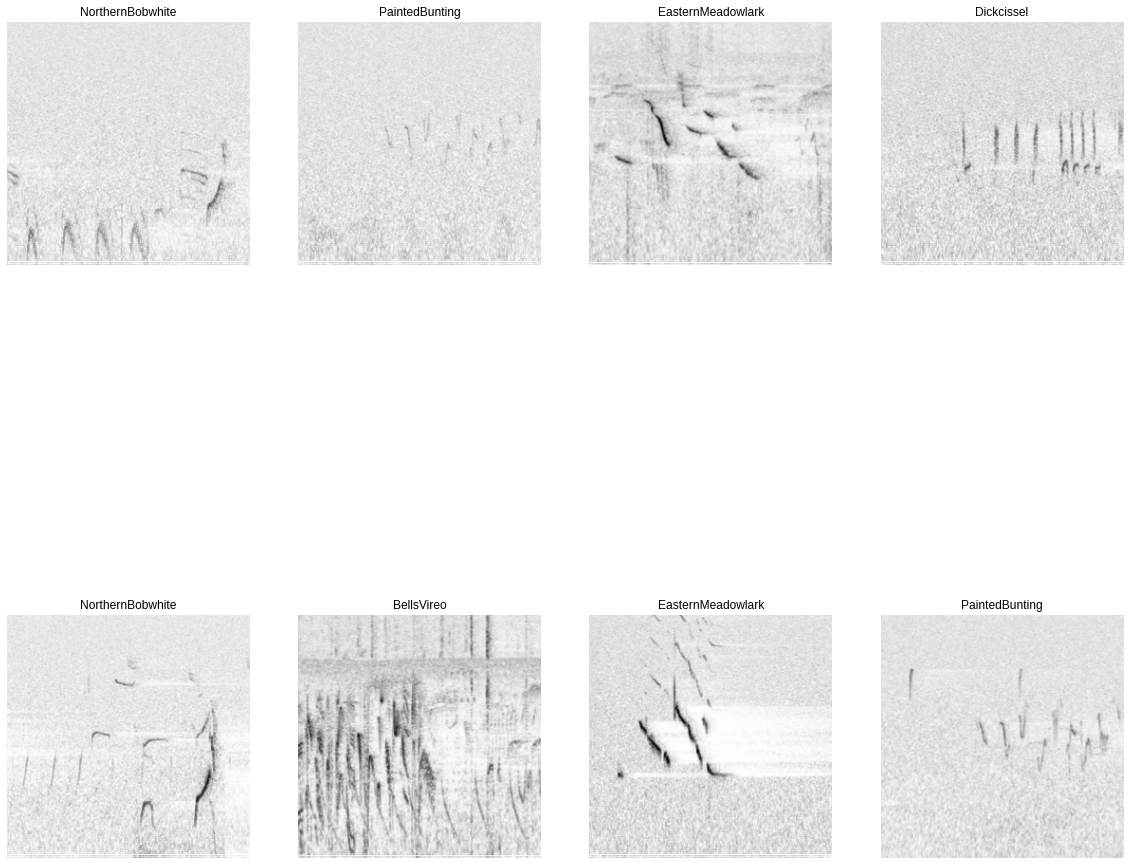

In [52]:
dls.show_batch(max_n=25, figsize=(20,20))

In [53]:
import torchvision.models as models

In [54]:
def F_score(output, label, threshold=0.2, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [55]:
models.resnet18

<function torchvision.models.resnet.resnet18(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> torchvision.models.resnet.ResNet>

In [56]:
learn = cnn_learner(dls, models.resnet18, pretrained=True, metrics=[partial(accuracy_multi, thresh=0.5),partial(mymodule.F_score, threshold=0.5)], loss_func=BCEWithLogitsLossFlat(thresh=0.5)).to_fp16()

SuggestedLRs(valley=0.002511886414140463)

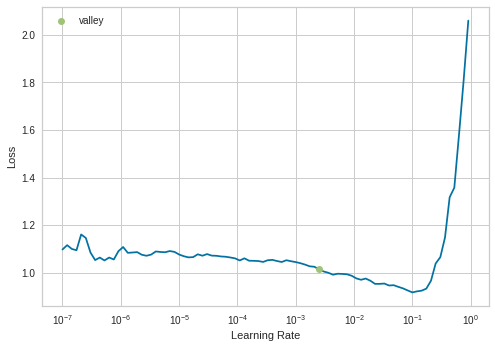

In [57]:
learn.lr_find()

In [ ]:
learn.fine_tune(epochs=8, base_lr=2e-3, freeze_epochs=2)

epoch,train_loss,valid_loss,accuracy_multi,F_score,time
0,0.219823,0.107654,0.960686,0.821627,03:34
1,0.138752,0.040761,0.987493,0.935018,03:36


epoch,train_loss,valid_loss,accuracy_multi,F_score,time
0,0.038065,0.016716,0.995052,0.978715,05:07
1,0.042554,0.012224,0.996805,0.986702,05:04
2,0.033262,0.006837,0.997701,0.990403,05:06
3,0.031118,0.007427,0.997935,0.993326,05:06
4,0.009583,0.005587,0.998364,0.994155,05:05
5,0.001949,0.002804,0.999065,0.996688,05:05


In [ ]:
#Note last refinement was to include f1 score and normalizing

In [ ]:
learn.save('testreserved_thresh05_resnet18')